In [1]:
# System libs
import os
import argparse
from distutils.version import LooseVersion
# Numerical libs
import numpy as np
import torch
import torch.nn as nn
from scipy.io import loadmat
import csv
# Our libs
from mit_semseg.dataset import TestDataset
from mit_semseg.models import ModelBuilder, SegmentationModule
from mit_semseg.utils import colorEncode, find_recursive, setup_logger
from mit_semseg.lib.nn import user_scattered_collate, async_copy_to
from mit_semseg.lib.utils import as_numpy
from PIL import Image
from tqdm import tqdm
from mit_semseg.config import cfg

In [23]:
colors = loadmat('data/color150.mat')['colors']
names = {}
with open('data/object150_info.csv') as f:
    reader = csv.reader(f)
    next(reader)
    for row in reader:
        names[int(row[0])] = row[5].split(";")[0]


def visualize_result(data, pred, cfg):
    (img, info) = data

    # print predictions in descending order
    pred = np.int32(pred)
    pixs = pred.size
    uniques, counts = np.unique(pred, return_counts=True)
    print("Predictions in [{}]:".format(info))
    for idx in np.argsort(counts)[::-1]:
        name = names[uniques[idx] + 1]
        ratio = counts[idx] / pixs * 100
        if ratio > 0.1:
            print("  {}: {:.2f}%".format(name, ratio))

    # colorize prediction
    pred_color = colorEncode(pred, colors).astype(np.uint8)

    # aggregate images and save
    im_vis = np.concatenate((img, pred_color), axis=1)

    img_name = info.split('/')[-1]
    display(Image.fromarray(im_vis))


def test(segmentation_module, loader, gpu):
    segmentation_module.eval()

    pbar = tqdm(total=len(loader))
    for batch_data in loader:
        # process data
        batch_data = batch_data[0]
        segSize = (batch_data['img_ori'].shape[0],
                   batch_data['img_ori'].shape[1])
        img_resized_list = batch_data['img_data']

        with torch.no_grad():
            scores = torch.zeros(1, cfg.DATASET.num_class, segSize[0], segSize[1])
            scores = async_copy_to(scores, gpu)

            for img in img_resized_list:
                feed_dict = batch_data.copy()
                feed_dict['img_data'] = img
                del feed_dict['img_ori']
                del feed_dict['info']
                feed_dict = async_copy_to(feed_dict, gpu)

                # forward pass
                pred_tmp = segmentation_module(feed_dict, segSize=segSize)
                scores = scores + pred_tmp / len(cfg.DATASET.imgSizes)

            _, pred = torch.max(scores, dim=1)
            pred = as_numpy(pred.squeeze(0).cpu())

        # visualization
        visualize_result(
            (batch_data['img_ori'], batch_data['info']),
            pred,
            cfg
        )

        pbar.update(1)


def main(cfg, gpu):
    torch.cuda.set_device(gpu)

    # Network Builders
    net_encoder = ModelBuilder.build_encoder(
        arch=cfg.MODEL.arch_encoder,
        fc_dim=cfg.MODEL.fc_dim,
        weights=cfg.MODEL.weights_encoder)
    net_decoder = ModelBuilder.build_decoder(
        arch=cfg.MODEL.arch_decoder,
        fc_dim=cfg.MODEL.fc_dim,
        num_class=cfg.DATASET.num_class,
        weights=cfg.MODEL.weights_decoder,
        use_softmax=True)

    crit = nn.NLLLoss(ignore_index=-1)

    segmentation_module = SegmentationModule(net_encoder, net_decoder, crit)

    # Dataset and Loader
    dataset_test = TestDataset(
        cfg.list_test,
        cfg.DATASET)
    loader_test = torch.utils.data.DataLoader(
        dataset_test,
        batch_size=cfg.TEST.batch_size,
        shuffle=False,
        collate_fn=user_scattered_collate,
        num_workers=5,
        drop_last=True)

    segmentation_module.cuda()

    # Main loop
    test(segmentation_module, loader_test, gpu)

    print('Inference done!')
    return segmentation_module

Loading weights for net_encoder
Loading weights for net_decoder
# samples: 1


  0%|          | 0/1 [00:00<?, ?it/s]

Predictions in [ADE_val_00001519.jpg]:
  wall: 18.98%
  ceiling: 13.26%
  sofa: 12.89%
  door: 9.54%
  shelf: 9.13%
  floor: 8.61%
  armchair: 6.36%
  fireplace: 5.07%
  coffee: 4.13%
  table: 2.42%
  cushion: 2.38%
  mirror: 1.37%
  curtain: 1.24%
  flower: 1.17%
  vase: 0.95%
  lamp: 0.69%
  painting: 0.50%
  chair: 0.49%
  cabinet: 0.29%
  book: 0.16%
  plate: 0.12%
  light: 0.12%


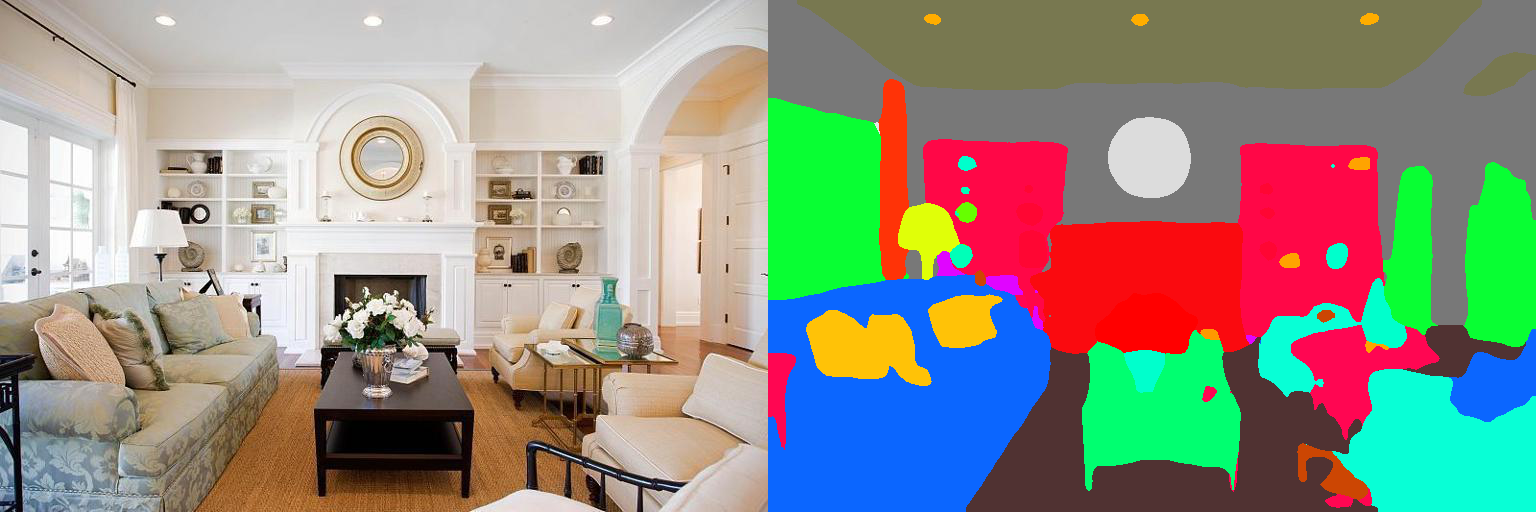

100%|██████████| 1/1 [00:01<00:00,  1.45s/it]

Inference done!


In [37]:
cfg.list_test = [{'fpath_img': 'ADE_val_00001519.jpg'}]
cfg.DIR = 'ade20k-resnet50dilated-ppm_deepsup'
cfg.MODEL.weights_encoder = os.path.join(
    cfg.DIR, 'encoder_' + cfg.TEST.checkpoint)
cfg.MODEL.weights_decoder = os.path.join(
    cfg.DIR, 'decoder_' + cfg.TEST.checkpoint)
    
model = main(cfg, 0)